# Machine Learning Applications of Iterated Prisoners Dilemma

## Imports

In [68]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import random
from sklearn.metrics import accuracy_score

import seaborn as sns

import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional

## Strategies

In [54]:
# Game Payoffs
payoff_matrix = {
    ('C', 'C'): (3, 3),
    ('C', 'D'): (0, 5),
    ('D', 'C'): (5, 0),
    ('D', 'D'): (1, 1)
}

def random_strategy(history, player):
    return random.choice(['C','D'])

def tit_for_tat(history, player):
    if not history:
        return 'C'
    last = history[-1]
    last_move = ""
    if player == 1:
        last_move = last[1]
    elif player == 2:
        last_move = last[0]
    return "D" if last_move == "D" else "C"

def always_cooperate(history, player):
    return 'C'

def always_defect(history, player):
    return 'D'

def grim_trigger(history, player):
    if not history:
        return 'C'
    opp_defected = any(
        (h[1]=='D' if player==1 else h[0]=='D')
        for h in history
    )
    return 'D' if opp_defected else 'C'

def tit_for_two_tats(history, player):
    if len(history) < 2:
        return 'C'
    last_two = history[-2:]
    opp_moves = [(h[1] if player==1 else h[0]) for h in last_two]
    return 'D' if all(m=='D' for m in opp_moves) else 'C'

def pavlov(history, player):
    if not history:
        return 'C'
    last = history[-1]
    payoff_p1, payoff_p2 = payoff_matrix[(last[0], last[1])]
    payoff = payoff_p1 if player==1 else payoff_p2
    last_action = last[0] if player==1 else last[1]
    if payoff >= 3:
        return last_action
    return 'C' if last_action=='D' else 'D'

def generous_tit_for_tat(history, player, generosity=0.3):
    if not history:
        return 'C'
    opp_last = history[-1][1] if player==1 else history[-1][0]
    if opp_last == 'C':
        return 'C'
    return 'C' if random.random() < generosity else 'D'

def soft_majority(history, player):
    if not history:
        return 'C'
    opp_moves = [h[1] if player==1 else h[0] for h in history]
    coop = opp_moves.count('C')
    defect = opp_moves.count('D')
    return 'C' if coop >= defect else 'D'

def alternator(history, player):
    round_num = len(history) + 1
    return 'C' if round_num % 2 == 1 else 'D'

def suspicious_tit_for_tat(history, player):
    if not history:
        return 'D'
    
    last = history[-1][1] if player == 1 else history[-1][0]
    return last

def tester(history, player):
    if len(history) == 0:
        return 'D'
    if len(history) == 1:
        return 'C'
    last = history[-1][1] if player == 1 else history[-1][0]
    return last

def limited_retaliation(history, player, m=2):
    if not history:
        return 'C'
    opp = [h[1] if player == 1 else h[0] for h in history]
    defections = [i for i, move in enumerate(opp) if move == 'D']
    if not defections:
        return 'C'
    last_def = defections[-1]
    current = len(history)
    if current <= last_def + m:
        return 'D'
    return 'C'

def gradual(history, player):
    opp = [h[1] if player == 1 else h[0] for h in history]
    d_count = opp.count('D')
    phase = d_count % 6
    return 'D' if phase in (0, 1) else 'C'

## Strategy Classification

### Setup

In [55]:
STRATEGIES = {
    'Tit-for-Tat': tit_for_tat,
    'Tit-for-2-Tat': tit_for_two_tats,
    "Suspicious-Tit-for-Tat": suspicious_tit_for_tat,
    'Grim Trigger': grim_trigger,
    'Pavlov': pavlov,
    'Always Cooperate': always_cooperate,
    'Generous TFT': generous_tit_for_tat,
    'Soft Majority': soft_majority,
    'Random Strategy': random_strategy,
    'Alternator': alternator,
    'Gradual': gradual,
    "Limited Retaliation": limited_retaliation,
    "Tester": tester,
}

def simulate_game(rounds, strat1, strat2):
    history = []
    for r in range(1, rounds+1):
        a1 = strat1(history, 1)
        a2 = strat2(history, 2)
        p1, p2 = payoff_matrix[(a1,a2)]
        history.append([r,a1, a2,p1,p2])
    total1 = sum(h[3] for h in history)
    total2 = sum(h[4] for h in history)
    if total1 > total2:
        winner = 1
    elif total2 > total1:
        winner = 2
    else:
        winner = 0
    return history, {'p1_total': total1, 'p2_total': total2}, winner

### Dataset

#### Generate Dataset

In [62]:
def generate_strategy_dataset(strategies, seq_len=10, games_per_strat=500):
    pair2id = {('C','C'):0, ('C','D'):1, ('D','C'):2, ('D','D'):3}
    X, y = [], []
    rowid = 0
    for label, strat in enumerate(strategies.values()):
        for _ in range(games_per_strat):
            history = []
            rand = random.choice(list(strategies.items()))[1]
            for _ in range(seq_len):
                a1 = strat(history, 1)
                a2 = random_strategy(history, 2)
                p1, p2 = payoff_matrix[(a1,a2)]
                history.append((a1,a2))
                rowid += 1
            tokens = [pair2id[p] for p in history]
            X.append(tokens)
            y.append(list(STRATEGIES.keys())[label])
    return np.array(X), np.array(y)

X, y = generate_strategy_dataset(STRATEGIES, seq_len=25, games_per_strat=5000)
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (65000, 25) y shape: (65000,)


#### Train Test Validation Split

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

### Naive Model: Untuned Random Forest

In [58]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=list(STRATEGIES.keys())))

                        precision    recall  f1-score   support

           Tit-for-Tat       1.00      1.00      1.00      2000
         Tit-for-2-Tat       0.88      0.96      0.92      2000
Suspicious-Tit-for-Tat       0.76      0.68      0.71      2000
          Grim Trigger       0.99      1.00      0.99      2000
                Pavlov       0.93      0.98      0.95      2000
      Always Cooperate       0.95      0.98      0.96      2000
          Generous TFT       0.95      0.99      0.97      2000
         Soft Majority       1.00      0.82      0.90      2000
       Random Strategy       0.90      0.76      0.83      2000
            Alternator       0.79      0.66      0.72      2000
               Gradual       0.70      0.84      0.77      2000
   Limited Retaliation       0.90      0.98      0.94      2000
                Tester       0.77      0.83      0.80      2000

              accuracy                           0.88     26000
             macro avg       0.88     

### Untuned XGBoost Model

In [59]:
clf = xgb.XGBClassifier(
    objective='multi:softmax',
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=3,
    random_state=1122,
    eval_metric='mlogloss',
    early_stopping_rounds=5,
    n_jobs=-1,
    device='cuda'
)

clf.fit(X_train, y_train_encoded, eval_set=[(X_train, y_train_encoded), (X_val, y_val_encoded)], verbose=False)

y_pred = le.inverse_transform(clf.predict(X_test))
print(classification_report(y_test, y_pred, target_names=list(STRATEGIES.keys())))

                        precision    recall  f1-score   support

           Tit-for-Tat       1.00      1.00      1.00      2000
         Tit-for-2-Tat       0.89      0.95      0.92      2000
Suspicious-Tit-for-Tat       0.98      0.90      0.94      2000
          Grim Trigger       0.99      1.00      1.00      2000
                Pavlov       0.93      0.97      0.95      2000
      Always Cooperate       0.99      0.98      0.98      2000
          Generous TFT       1.00      1.00      1.00      2000
         Soft Majority       1.00      0.96      0.98      2000
       Random Strategy       0.87      0.82      0.85      2000
            Alternator       0.76      0.77      0.76      2000
               Gradual       0.76      0.76      0.76      2000
   Limited Retaliation       0.98      0.98      0.98      2000
                Tester       0.93      1.00      0.96      2000

              accuracy                           0.93     26000
             macro avg       0.93     

### XGBoost Model Tuning

#### Grid Search

In [9]:
clf = xgb.XGBClassifier(
    objective='multi:softmax',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=1122,
    eval_metric='mlogloss',
    n_jobs=-1,
    device='cuda'
)

param_grid = {
    'n_estimators': [10, 50, 100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

fit_params = {
    "eval_set": [(X_val, y_val_encoded)],
    "verbose": False
}

grid = GridSearchCV(clf, param_grid, cv=5)
grid.fit(X_train, y_train_encoded, **fit_params)

print("\nBest Accuracy: {:.4f}".format(grid.best_score_))

clf = grid.best_estimator_.clf_
print("\nFinal model parameters:")
print(clf.get_params())

KeyboardInterrupt: 

#### Tuned XGBoost Classification Report

In [60]:
y_pred = le.inverse_transform(clf.predict(X_test))
print(classification_report(y_test, y_pred, target_names=list(STRATEGIES.keys())))

                        precision    recall  f1-score   support

           Tit-for-Tat       1.00      1.00      1.00      2000
         Tit-for-2-Tat       0.89      0.95      0.92      2000
Suspicious-Tit-for-Tat       0.98      0.90      0.94      2000
          Grim Trigger       0.99      1.00      1.00      2000
                Pavlov       0.93      0.97      0.95      2000
      Always Cooperate       0.99      0.98      0.98      2000
          Generous TFT       1.00      1.00      1.00      2000
         Soft Majority       1.00      0.96      0.98      2000
       Random Strategy       0.87      0.82      0.85      2000
            Alternator       0.76      0.77      0.76      2000
               Gradual       0.76      0.76      0.76      2000
   Limited Retaliation       0.98      0.98      0.98      2000
                Tester       0.93      1.00      0.96      2000

              accuracy                           0.93     26000
             macro avg       0.93     

#### Optimal Number Of Rounds

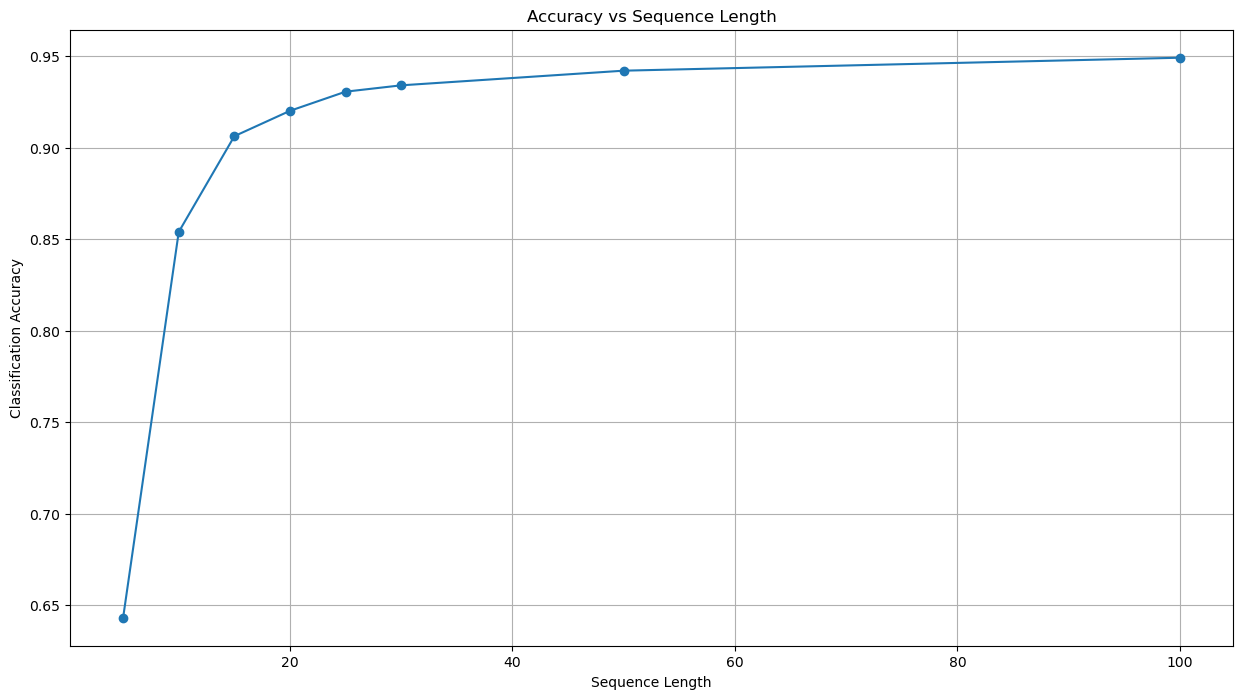

In [61]:
sequence_lengths = [5, 10, 15, 20, 25, 30, 50, 100]
accuracies = []

for L in sequence_lengths:
    X, y = generate_strategy_dataset(STRATEGIES, seq_len=L, games_per_strat=5000)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)
    
    le = LabelEncoder()
    
    y_train_encoded = le.fit_transform(y_train)
    y_val_encoded = le.transform(y_val)
    y_test_encoded = le.transform(y_test)
    
    clf.fit(X_train, y_train_encoded, eval_set=[(X_train, y_train_encoded), (X_val, y_val_encoded)], verbose=False)

    acc = clf.score(X_test, y_test_encoded)
    accuracies.append(acc)

plt.figure(figsize=(15, 8))
plt.plot(sequence_lengths, accuracies, marker='o')
plt.xlabel('Sequence Length')
plt.ylabel('Classification Accuracy')
plt.title('Accuracy vs Sequence Length')
plt.grid(True)
plt.show()

### LSTM Model

#### Simple LSTM

In [65]:
num_strats = len(STRATEGIES)
seq_len = X.shape[1]
vocab_size = 4

inp = Input(shape=(seq_len,), dtype="int32")
x = Embedding(vocab_size, 16, input_length=seq_len)(inp)
x = LSTM(4, return_sequences=False)(x)
x = Dropout(0.2)(x)
out = Dense(num_strats, activation="softmax")(x)
model = Model(inp, out)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

le = LabelEncoder()
le.fit(y_train)

y_train_cat = le.transform(y_train)

history = model.fit(
    X_train, y_train_cat,
    validation_split=0.1,
    epochs=30, batch_size=128
)

y_test_cat = le.transform(y_test)
loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
y_pred_cat = model.predict(X_test).argmax(axis=-1)
print(f"LSTM test accuracy: {acc:.3f}")

Epoch 1/30
220/220 [==============================] - 2s 4ms/step - loss: 2.4646 - accuracy: 0.1227 - val_loss: 2.2647 - val_accuracy: 0.2173
Epoch 2/30
220/220 [==============================] - 1s 3ms/step - loss: 2.1029 - accuracy: 0.2319 - val_loss: 1.9006 - val_accuracy: 0.3128
Epoch 3/30
220/220 [==============================] - 1s 3ms/step - loss: 1.8787 - accuracy: 0.2963 - val_loss: 1.7405 - val_accuracy: 0.3798
Epoch 4/30
220/220 [==============================] - 1s 3ms/step - loss: 1.7780 - accuracy: 0.3351 - val_loss: 1.6467 - val_accuracy: 0.4144
Epoch 5/30
220/220 [==============================] - 1s 3ms/step - loss: 1.7142 - accuracy: 0.3555 - val_loss: 1.5787 - val_accuracy: 0.4295
Epoch 6/30
220/220 [==============================] - 1s 3ms/step - loss: 1.6683 - accuracy: 0.3544 - val_loss: 1.5405 - val_accuracy: 0.4208
Epoch 7/30
220/220 [==============================] - 1s 3ms/step - loss: 1.6442 - accuracy: 0.3575 - val_loss: 1.4993 - val_accuracy: 0.4676
Epoch 

#### Simple LSTM Classification Report

In [66]:
y_test_stat = le.inverse_transform(y_test_cat)
y_test_pred_stat = le.inverse_transform(y_pred_cat)
print(classification_report(y_test_pred_stat, y_test_stat, target_names=list(STRATEGIES.keys())))

                        precision    recall  f1-score   support

           Tit-for-Tat       0.07      0.54      0.13       270
         Tit-for-2-Tat       0.99      0.63      0.77      3182
Suspicious-Tit-for-Tat       0.67      0.47      0.55      2839
          Grim Trigger       0.63      0.38      0.47      3305
                Pavlov       0.97      0.80      0.88      2443
      Always Cooperate       0.94      0.69      0.80      2699
          Generous TFT       0.31      0.33      0.32      1856
         Soft Majority       0.10      0.27      0.14       730
       Random Strategy       0.02      0.36      0.05       138
            Alternator       0.92      0.58      0.71      3142
               Gradual       0.45      0.72      0.56      1262
   Limited Retaliation       0.59      0.67      0.63      1746
                Tester       1.00      0.84      0.91      2388

              accuracy                           0.59     26000
             macro avg       0.59     

#### Tuned LSTM

In [67]:
def build_model(hp):
    seq_len, num_classes = 25, 16
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=hp.Int('embed_dim', 8, 64, step=8),
        input_length=seq_len
    ))
    for i in range(hp.Int('num_layers', 1, 3)):
        return_seq = (i < hp.get('num_layers')-1)
        model.add(Bidirectional(
            LSTM(
                units=hp.Int(f'units_{i}', 16, 128, step=16),
                dropout=hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1),
                recurrent_dropout=hp.Float(f'rec_dropout_{i}', 0.0, 0.5, step=0.1),
                return_sequences=return_seq
            )
        ))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam','rmsprop']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuner_dir',
    project_name='25seq_strategy'
)

tuner.search(
    X_train, y_train_encoded,
    validation_data=(X_val, y_val_encoded),
    epochs=5,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

best_hp = tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)

Trial 5 Complete [00h 01m 59s]
val_accuracy: 0.9375640749931335

Best val_accuracy So Far: 0.9385897517204285
Total elapsed time: 00h 10m 22s
{'embed_dim': 40, 'num_layers': 1, 'units_0': 96, 'dropout_0': 0.4, 'rec_dropout_0': 0.2, 'optimizer': 'adam', 'units_1': 128, 'dropout_1': 0.0, 'rec_dropout_1': 0.30000000000000004}


#### Tuned LSTM Metrics

In [69]:
best_model = tuner.get_best_models(1)[0]
y_test_cat = le.transform(y_test)
lstm_loss, acc = best_model.evaluate(X_test, y_test_cat, verbose=0)
y_pred_cat = best_model.predict(X_test).argmax(axis=-1)
print(f"LSTM test accuracy: {acc:.3f}")

813/813 [==============================] - 4s 5ms/step
LSTM test accuracy: 0.937


#### Tuned LSTM Classification Report

In [70]:
y_test_stat = le.inverse_transform(y_test_cat)
y_test_pred_stat = le.inverse_transform(y_pred_cat)
print(classification_report(y_test_pred_stat, y_test_stat, target_names=list(STRATEGIES.keys())))

                        precision    recall  f1-score   support

           Tit-for-Tat       1.00      1.00      1.00      2000
         Tit-for-2-Tat       0.92      0.91      0.92      2006
Suspicious-Tit-for-Tat       0.97      0.99      0.98      1942
          Grim Trigger       1.00      1.00      1.00      2008
                Pavlov       0.97      0.95      0.96      2052
      Always Cooperate       0.99      0.99      0.99      1990
          Generous TFT       1.00      0.99      0.99      2022
         Soft Majority       0.98      1.00      0.99      1963
       Random Strategy       0.86      0.87      0.87      1959
            Alternator       0.71      0.78      0.74      1828
               Gradual       0.80      0.73      0.76      2173
   Limited Retaliation       0.99      0.99      0.99      2002
                Tester       1.00      0.97      0.99      2055

              accuracy                           0.94     26000
             macro avg       0.94     

## Predictive AI Player

### Setup

In [83]:
STRATEGIES = {
    'Tit-for-Tat': tit_for_tat,
    'Always Cooperate': always_cooperate,
    'Grim Trigger': grim_trigger,
    'Tit-for-Two-Tats': tit_for_two_tats,
    'Pavlov': pavlov,
    'Generous TFT': generous_tit_for_tat,
    'Soft Majority': soft_majority,
    'Alternator': alternator,
    'Suspicious TFT': suspicious_tit_for_tat,
    'Tester': tester,
    'Limited Retaliation': limited_retaliation,
    'Gradual': gradual,
    'Random': random_strategy
}

pair2id = {('C','C'):0, ('C','D'):1, ('D','C'):2, ('D','D'):3}

def make_move_data(strat, seq_len=10, n_games=5000):
    X, y = [], []
    for _ in range(n_games):
        history = []
        for _ in range(seq_len + 1):
            a1 = strat(history, 1)
            a2 = tit_for_tat(history, 2)
            history.append((a1, a2))
        window = history[:seq_len]
        feats = []
        for p1, p2 in window:
            feats.append(1 if p1 == 'D' else 0)
            feats.append(1 if p2 == 'D' else 0)
        next_opp_move = history[seq_len][0]
        X.append(feats)
        y.append(1 if next_opp_move == 'D' else 0)
    return np.array(X), np.array(y)

### Dataset

#### Generate

In [87]:
L = 50
X, y = [], []
for key, strategy in STRATEGIES.items():
    print("Generating data for", key)
    X_temp, y_temp = make_move_data(strategy, seq_len=L, n_games=50000)
    X.append(X_temp)
    y.append(y_temp)

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

print("X shape:", X.shape, "y shape:", y.shape)

Generating data for Tit-for-Tat
Generating data for Always Cooperate
Generating data for Grim Trigger
Generating data for Tit-for-Two-Tats
Generating data for Pavlov
Generating data for Generous TFT
Generating data for Soft Majority
Generating data for Alternator
Generating data for Suspicious TFT
Generating data for Tester
Generating data for Limited Retaliation
Generating data for Gradual
Generating data for Random
X shape: (650000, 100) y shape: (650000,)


#### Train Test Validation Split

In [88]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

### XGBoost Model

### Untuned

Next‐move accuracy: 0.9616461538461538

=== Classification Report ===

              precision    recall  f1-score   support

           0     0.9566    0.9978    0.9768    210002
           1     0.9886    0.8099    0.8904     49998

    accuracy                         0.9616    260000
   macro avg     0.9726    0.9038    0.9336    260000
weighted avg     0.9628    0.9616    0.9601    260000



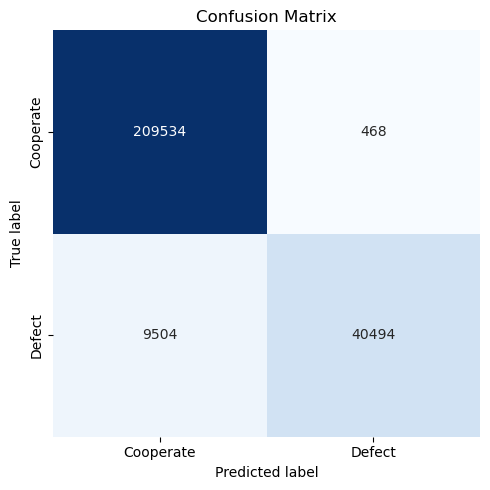

In [91]:
clf = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    random_state=1122,
    eval_metric='error',
    early_stopping_rounds=10,
    n_jobs=-1
)

clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
y_pred = clf.predict(X_test)
print("Next‐move accuracy:", accuracy_score(y_test, y_pred))

print("\n=== Classification Report ===\n")
print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Cooperate", "Defect"],
            yticklabels=["Cooperate", "Defect"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

### GridSearchCV

In [32]:
param_grid = {
    'n_estimators': [10, 50, 100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

fit_params = {"eval_set" : [(X_val, y_val)], 'verbose' : False}

grid = GridSearchCV(clf, param_grid, cv=5)
grid.fit(X_train, y_train, fit_params=fit_params)

print("\nBest Accuracy: {:.4f}".format(grid.best_score_))

clf = grid.best_estimator_.clf_
print("\nFinal model parameters:")
print(clf.get_params())

KeyboardInterrupt: 

### AI Player Strategy

In [80]:
def policy(history, player):
    hist = history[-L:] if len(history)>=L else [('C','C')]* (L-len(history)) + history
    feat = []
    for p1,p2 in hist:
        feat.extend([1 if p1=='D' else 0, 1 if p2=='D' else 0])
    prob_comply = clf.predict_proba([feat])[0][1]
    return 'C' if prob_comply > 0.5 else 'D'

### Tournament

#### Setup

In [81]:
def simulate_game(rounds, strat1, strat2):
    moves_history = []
    full_history  = []
    for r in range(1, rounds+1):
        a1 = strat1(moves_history, 1)
        a2 = strat2(moves_history, 2)
        p1, p2 = payoff_matrix[(a1,a2)]
        moves_history.append((a1, a2))
        full_history.append({
            'round':   r,
            'p1':      a1,
            'p2':      a2,
            'payoff1': p1,
            'payoff2': p2
        })
    total1 = sum(r['payoff1'] for r in full_history)
    total2 = sum(r['payoff2'] for r in full_history)
    if total1 > total2:
        winner = 1
    elif total2 > total1:
        winner = 2
    else:
        winner = 0
    return full_history, {'p1_total': total1, 'p2_total': total2}, winner


STRATEGIES = {
    'Tit-for-Tat': tit_for_tat,
    'Always Cooperate': always_cooperate,
    'Grim Trigger': grim_trigger,
    'Tit-for-Two-Tats': tit_for_two_tats,
    'Pavlov': pavlov,
    'Generous TFT': generous_tit_for_tat,
    'Soft Majority': soft_majority,
    'Alternator': alternator,
    'Suspicious TFT': suspicious_tit_for_tat,
    'Tester': tester,
    'Limited Retaliation': limited_retaliation,
    'Gradual': gradual,
    "Random": random_strategy,
    'AI': policy
}

def tournament(strategies, rounds=1000, games_per_strat=10):
    total_payoffs = {name: 0 for name in strategies}
    win_counts    = {name: 0 for name in strategies}
    matches_per_strategy = len(strategies) - 1
    for name1, strat1 in strategies.items():
        for name2, strat2 in strategies.items():
            if name1 == name2:
                continue
            for r in range(games_per_strat):
                _, totals, winner = simulate_game(rounds, strat1, strat2)
                total_payoffs[name1] += totals['p1_total']
                if winner == 1:
                    win_counts[name1] += 1
    avg_payoffs = {
        name: total_payoffs[name] / matches_per_strategy
        for name in strategies
    }
    best_by_payoff = max(avg_payoffs, key=avg_payoffs.get)
    best_by_wins   = max(win_counts,    key=win_counts.get)
    return avg_payoffs, win_counts, best_by_payoff, best_by_wins

#### Results

In [82]:
rounds_list = [50, 100, 200, 300]
games_per_strat = 10

win_ratio = []
average_points = []

win_ratios   = {s: [] for s in STRATEGIES}
avg_payoffs  = {s: [] for s in STRATEGIES}

for rounds_per_match in rounds_list:
    tot_payoffs, win_counts, best_payoff_strat, best_wins_strat = \
        tournament(STRATEGIES, rounds=rounds_per_match, games_per_strat=games_per_strat)
    
    print(f"Rounds per match: {rounds_per_match}\n")
    print("Average payoffs vs all opponents:")
    for name, avg in sorted(tot_payoffs.items(), key=lambda x: -x[1]):
        print(f"  {name:20s}: {avg:.2f}")
    
    print("\nWin counts vs all opponents:")
    for name, wins in sorted(win_counts.items(), key=lambda x: -x[1]):
        print(f"  {name:20s}: {wins}/{(len(STRATEGIES)-1)*games_per_strat}")
    
    print("\n=== Tournament Winners ===")
    print(f"Best average payoff:     {best_payoff_strat}")
    print(f"Most wins:                {best_wins_strat}")
    
    total_matches = (len(STRATEGIES)-1) * games_per_strat
    for s in STRATEGIES:
        win_ratios[s].append(win_counts[s] / total_matches)
        avg_payoffs[s].append(tot_payoffs[s])
    
    win_ratio.append(win_counts['AI']/((len(STRATEGIES)-1)*games_per_strat))
    average_points.append(tot_payoffs['AI'])

Rounds per match: 50

Average payoffs vs all opponents:
  Tit-for-Tat         : 1329.92
  Generous TFT        : 1325.77
  Tit-for-Two-Tats    : 1308.85
  Soft Majority       : 1299.15
  Grim Trigger        : 1284.77
  Pavlov              : 1273.15
  Gradual             : 1271.00
  Limited Retaliation : 1254.77
  Alternator          : 1242.54
  Always Cooperate    : 1148.54
  Suspicious TFT      : 1135.62
  Tester              : 1124.54
  Random              : 1110.38
  AI                  : 1056.92

Win counts vs all opponents:
  AI                  : 120/130
  Alternator          : 76/130
  Random              : 57/130
  Suspicious TFT      : 55/130
  Gradual             : 37/130
  Tester              : 32/130
  Grim Trigger        : 30/130
  Limited Retaliation : 30/130
  Soft Majority       : 16/130
  Pavlov              : 2/130
  Tit-for-Tat         : 0/130
  Always Cooperate    : 0/130
  Tit-for-Two-Tats    : 0/130
  Generous TFT        : 0/130

=== Tournament Winners ===
Best ave

#### Tournament Results Plot

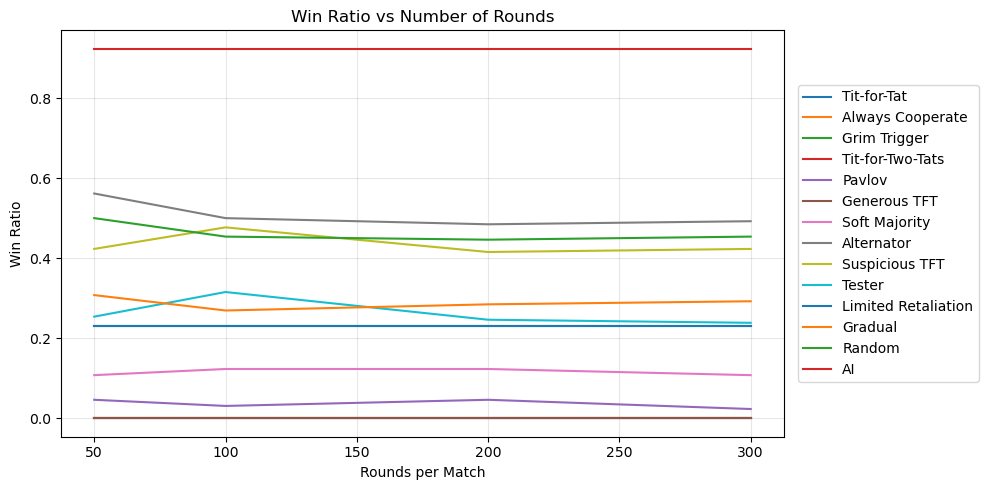

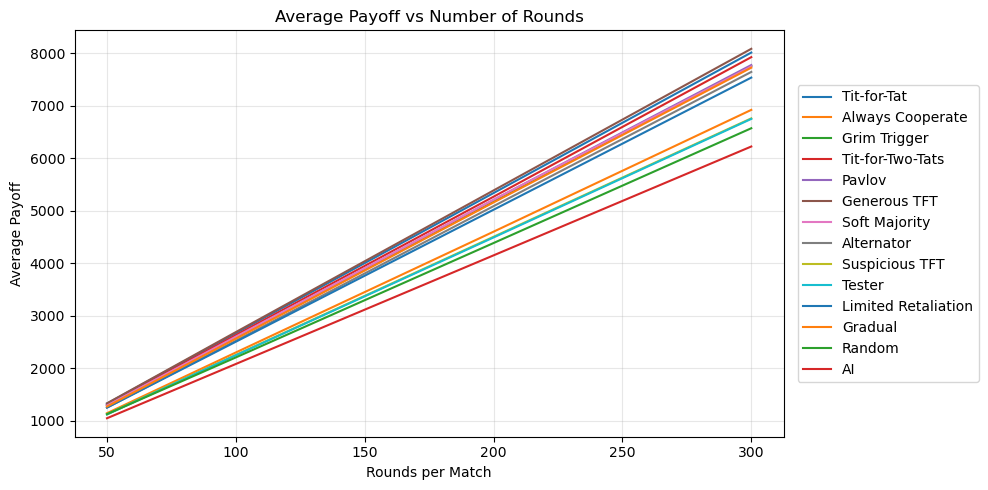

In [52]:
plt.figure(figsize=(10, 5))
for s in STRATEGIES:
    plt.plot(rounds_list, win_ratios[s], label=s)
plt.xlabel('Rounds per Match')
plt.ylabel('Win Ratio')
plt.title('Win Ratio vs Number of Rounds')
plt.legend(
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0
)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for s in STRATEGIES:
    plt.plot(rounds_list, avg_payoffs[s], label=s)
plt.xlabel('Rounds per Match')
plt.ylabel('Average Payoff')
plt.title('Average Payoff vs Number of Rounds')
plt.legend(
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0
)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()